<hr/>
		<div align=center>
		    <font color=black size=6>
			    <br />
        DIP Project
        <br />
        HC measurement from ultrasound medical images
			</font>
    <br/>

Student Number = 98102002    
Name = Shaghayegh Ataei

#Importing

In [ ]:
from skimage import io
from sklearn import cluster
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import pandas as pd
from PIL import Image
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets, models
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset, DataLoader


#Classical Method

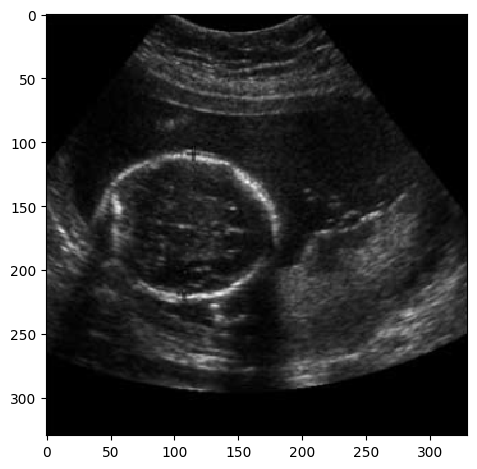

In [ ]:
# loading the "example.png":
image = io.imread('/content/exmaple.png',as_gray=True)
h, w = image.shape
io.imshow(image)
io.show()

##Classification via K-means

Here, we will use cluster.KMeans method in sklearn. For classifying the image in to 3 groups, we set the k = 3.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


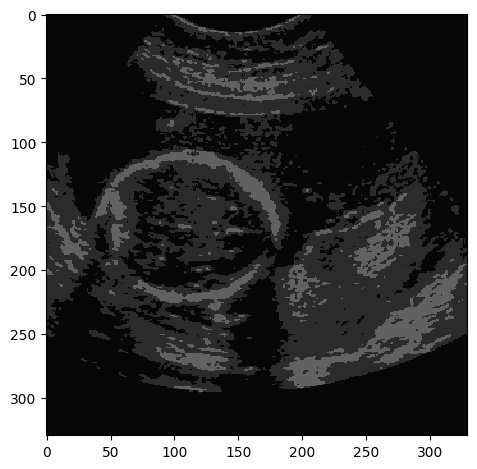

In [ ]:
image_2d = image.reshape(h*w,1)
#number of classes:
k = 3
#running k-means:
kmeans_cluster = cluster.KMeans(n_clusters=int(k))
kmeans_cluster.fit(image_2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

#rescale the results to 0-255:
newimage = cluster_centers[cluster_labels].reshape(h, w)*255.0
newimage = newimage.astype('uint8')

#showing the classification result:
io.imshow(newimage)
io.show()



Now for depicting only th "bright" part, we create a complete zero matrix and put 255 just in pixels in the "bright" cluster.

In the cell below, "ind2" is the array of "bright" cluster pixel's indexes.

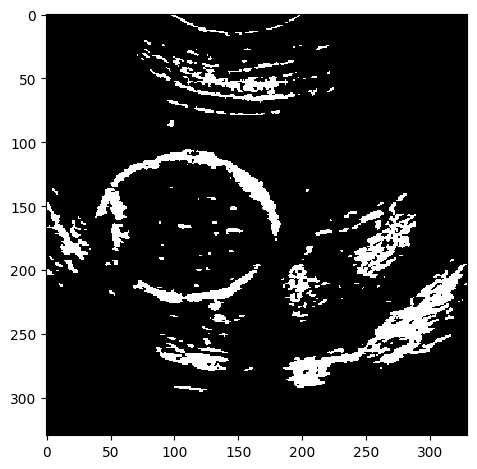

In [ ]:
ind0 = np.where(cluster_labels == 0)
ind1 = np.where(cluster_labels == 1)
ind2 = np.where(cluster_labels == 2)

#put 255 for pixels in bright class:
new_im = np.zeros((h*w, 1))
for ind in ind2[0]:
  new_im[ind] = 255
new_im = new_im.reshape(h, w)
new_im = new_im.astype('uint8')

#plotting the result:
io.imshow(new_im)
io.show()

##Denoising via Morphologicl transforms




For removing the small white parts, we apply "closing" and "opening" (in order) with a ellipse structuring element.

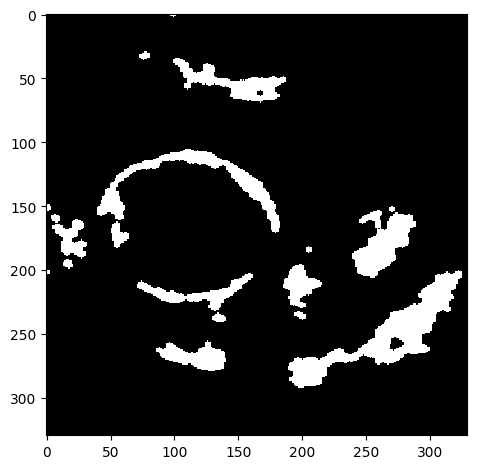

In [ ]:
img = new_im.copy()
#defining SE:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
#closing & opening:
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
#plotting the result:
io.imshow(opening)


##Ellipse Detection via RHT

For applying hough transform, first we apply a canny edge detection on the previous part's result:

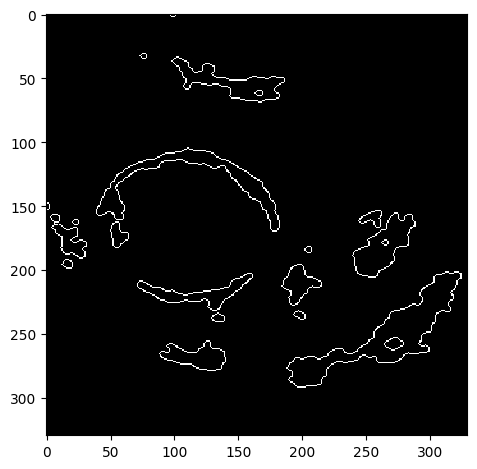

In [ ]:
edges = cv2.Canny(opening,20, 200)
io.imshow(edges)

Now we use findContours method and then fitEllipse, which works as an RHT

In [ ]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
max_contour = [1]
for i in range(len(contours)):
  if len(contours[i])>len(max_contour):
    max_contour = contours[i]

#ellipse's charactristic:
(cx, cy), (a, b), angle = cv2.fitEllipse(max_contour)

At last, we will plot the detected ellipse, on the original image:

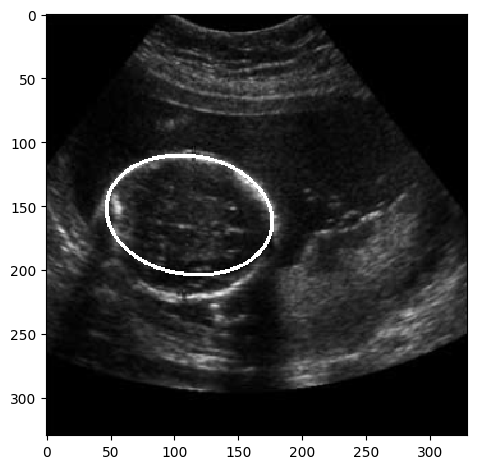

In [ ]:
ellipse = (cx, cy), (a, b), angle
image = io.imread('/content/exmaple.png',as_gray=True)
im = image.copy()
im = cv2.ellipse(im, ellipse, 1, thickness = 2)

io.imshow(im)

#Deep Learning Method

##Segmentation Method

###Data preparation

In [ ]:
train_datINF = pd.read_csv('/content/training_set_pixel_size_and_HC.csv')
train_data_IMGname = train_datINF['filename'].values

We create an ellipse like mask as training labels, from annotation files.

We ran this function one time, and save the masks as new labels.
so each time we load the new dataset for running the network, there is no need to run this cell for the second time.

In [ ]:
for data in train_data_IMGname:
  name = data[0:len(data)-4] #deleting ".png" from the name
  img =  cv2.imread('/content/drive/MyDrive/HC18/'+name+'_Annotation.png',0)
  im = img.copy()
  im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
  contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    ellipse = cv2.fitEllipse(c)
    cv2.ellipse(im, ellipse, (255,255,255), -1)
  #saving the new label:
  cv2.imwrite('/content/drive/MyDrive/Mask/'+name+'_Annotation.png', im)



In [ ]:
#Data set generating:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_size = (572, 572)
y_size = (572, 572)

class Data(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):

        self.x_train = sorted(glob.glob('/content/drive/MyDrive/training_set/*HC.png'))
        self.y_train = sorted(glob.glob('/content/drive/MyDrive/training_set/*_Annotation.png'))

        self.x_val = sorted(glob.glob('/content/drive/MyDrive/validation_set/*HC.png'))
        self.y_val = sorted(glob.glob('/content/drive/MyDrive/validation_set/*_Annotation.png'))
        self.data = data

    def __len__(self):

        if(self.data == 'train'):
            return len(self.x_train)

        elif(self.data == 'validate'):
            return len(self.x_val)


    def __getitem__(self, idx):

        if(self.data == 'train'):
            x = np.array(Image.open(self.x_train[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            y = np.array(Image.open(self.y_train[idx]).convert("L").resize(y_size)).reshape(1, 572, 572)
            return torch.from_numpy(x).float().to(device), torch.from_numpy(y).float().to(device)

        elif(self.data == 'validate'):
            x = np.array(Image.open(self.x_val[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            y = np.array(Image.open(self.y_val[idx]).convert("L").resize(y_size)).reshape(1, 572, 572)
            return torch.from_numpy(x).float().to(device), torch.from_numpy(y).float().to(device)

###Post-processing functions

Here we implement the needed post-processing functions for detecting an ellipse on the image.

In [ ]:
def Ellipse_fitting(img):
  #the result of the net has 2 equal channels, for using the findcontour function, we just pick one of them:
  contours, hierarchy = cv2.findContours(img[0,0,:,:].astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  max_contour = [1]
  for i in range(len(contours)):
    if len(contours[i])>len(max_contour):
      max_contour = contours[i]

  #ellipse's charactristic:
  (cx, cy), (a, b), angle = cv2.fitEllipse(max_contour)
  return (cx, cy), (a, b), angle

def HC_param(ellipse):
  cx, cy, a, b, angle = ellipse
  h = (a-b)**2 / (a+b)**2
  HC = math.pi * (a + b)*(1 + (3*h)/(10+np.sqrt(4-3*h)))
  return HC

###U-Net

In [ ]:
class sequential(nn.Module):

    def __init__(self, input_channels, output_channels, down=True):
        super(sequential, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace = True),
                                   nn.Dropout(0.5),
                                  )
        self.conv2 = nn.Sequential(nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace = True),
                                   nn.Dropout(0.5),
                                  )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)+x1
        return x2

class down(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(down, self).__init__()
        self.conv = nn.Sequential(nn.MaxPool2d(2),
                                  sequential(input_channels, output_channels),
                                 )

    def forward(self,x):
        x = self.conv(x)
        return x

class up(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(input_channels//2, input_channels//2, kernel_size=2, stride=2)
        self.conv = sequential(input_channels, output_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff1 = x2.shape[2]-x1.shape[2]
        diff2 = x2.shape[3]-x1.shape[3]
        x1 = F.pad(x1, pad=(diff1//2, diff1-diff1//2, diff2//2, diff2-diff2//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        self.conv0 = sequential(1, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 256)
        self.up1 = up(512, 128)
        self.up2 = up(256, 64)
        self.up3 = up(128, 64)
        self.conv_end = nn.Sequential(nn.Conv2d(64, 1, kernel_size=1),
                                 nn.Sigmoid())

    def forward(self, x):

        xin = self.conv0(x)
        xd1 = self.down1(xin)
        xd2 = self.down2(xd1)
        xd3 = self.down3(xd2)
        xu1 = self.up1(xd3, xd2)
        xu2 = self.up2(xu1, xd1)
        xu3 = self.up3(xu2, xin)
        y   = self.conv_end(xu3)
        return y

model = Unet()

In [ ]:
#training:
def Accuracy(y_hat, y):
  yf = torch.flatten(y)
  yf_hat = torch.flatten(y_hat)
  intersection = torch.sum(yf * yf_hat)
  return (2. * intersection) / (torch.sum(yf) + torch.sum(yf_hat))

lossF = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

batch_size = 2


train = Data('train', None)
val = Data('validate', None)
train_generator = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True, num_workers=0)
val_generator = torch.utils.data.DataLoader(val, batch_size=2, shuffle=True, num_workers=0)

epochs = 1

for epoch in range(epochs):

    train_loss = 0
    validation_loss = 0
    validation_accuracy = 0
    val_result = []
    for i, data in enumerate(train_generator):
        #if(i%100==0):
        #  print(i)
        img, label = data
        label = label/255
        y = model(img)
        loss = lossF(y, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    #validation set:
    with torch.no_grad():
        for i, data in enumerate(val_generator):
            img, label = data
            label = label/255
            y = model(img)
            y = torch.round(y)
            loss = lossF(y, label)
            validation_loss += loss.item()
            validation_accuracy  += Accuracy(y, label)
            val_result.append(y)

    train_loss = train_loss / len(train)
    validation_loss = validation_loss / len(val)
    validation_accuracy = validation_accuracy / len(val)


###U-Net result on two image

<ipython-input-134-587068c01717>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  res = np.array(res)
<ipython-input-134-587068c01717>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res)


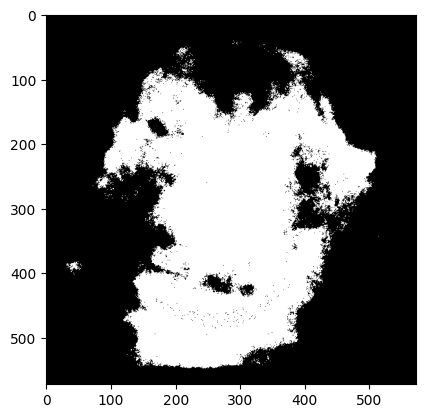

In [ ]:
res = val_result.copy()
res = np.array(res)
#predicted label
pred = res[91].numpy()
plt.imshow(pred[0,0,:,:], cmap='gray')

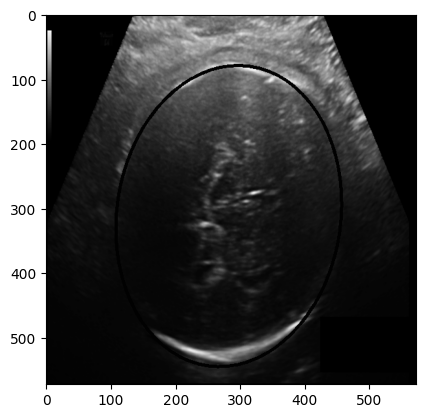

In [ ]:
#Ellipse fitting via RHT:
(cx, cy), (a, b), angle = Ellipse_fitting(pred )
ellipse = (cx, cy), (a, b), angle
#plot the ellipse on the original image:(we used the 91th validation data result which is a good one)
x = np.array(Image.open('/content/drive/MyDrive/validation_set/798_HC.png').convert("L").resize(x_size)).reshape(1, 572, 572)
imm = x[0, :,:].copy()
imm = cv2.ellipse(imm, ellipse, 1, thickness = 3)
plt.imshow(imm, cmap='gray')

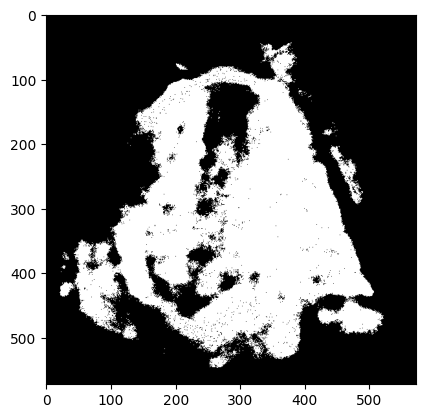

In [ ]:
#predicted label
pred = res[45].numpy()
plt.imshow(pred[0,0,:,:], cmap='gray')

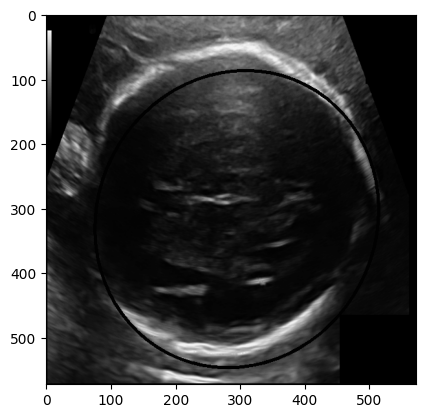

In [ ]:
(cx, cy), (a, b), angle = Ellipse_fitting(pred )
ellipse = (cx, cy), (a, b), angle
#plot the ellipse on the original image:(we used the 91th validation data result which is a good one)
x = np.array(Image.open('/content/drive/MyDrive/validation_set/687_HC.png').convert("L").resize(x_size)).reshape(1, 572, 572)
imm = x[0, :,:].copy()
imm = cv2.ellipse(imm, ellipse, 1, thickness = 3)
plt.imshow(imm, cmap='gray')

##Regression Method

###Data preparation

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_size = (572, 572)
y_size = (572, 572)

class Data(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):

        # set 'head circumference (mm)', 'pixel size(mm)' as training labels:
        HC_df =pd.read_csv('/content/training_set_pixel_size_and_HC.csv')
        HC_label = HC_df[['head circumference (mm)', 'pixel size(mm)']]
        HC_label = np.array(HC_label)

        self.x_train = sorted(glob.glob('/content/drive/MyDrive/training_set/*HC.png'))
        self.y_train = HC_label[0:801, :]

        self.x_val = sorted(glob.glob('/content/drive/MyDrive/validation_set/*HC.png'))
        self.y_val = HC_label[801:, :]
        self.data = data

        self.transform = transforms.Compose([
             transforms.Grayscale(num_output_channels=3),
             transforms.Resize(size=224),
             #transforms.RandomRotation(degrees=10),
             #transforms.RandomHorizontalFlip(),
             transforms.CenterCrop(size=224),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):

        if(self.data == 'train'):
            return len(self.x_train)

        elif(self.data == 'validate'):
            return len(self.x_val)


    def __getitem__(self, idx):

        if(self.data == 'train'):
            x = self.transform(Image.open(self.x_train[idx]))
            y = self.y_train[idx]
            return torch.from_numpy(np.array(x)).float().to(device), torch.from_numpy(np.array(y)).float().to(device)

        elif(self.data == 'validate'):
            x = self.transform(Image.open(self.x_val[idx]))
            y = self.y_val[idx]
            return torch.from_numpy(np.array(x)).float().to(device), torch.from_numpy(np.array(y)).float().to(device)

###VGG-16

In [ ]:
model = models.vgg16(weights = 'IMAGENET1K_V1')  #the default weights of vgg16 is IMAGENET1K_V1
n_inputs = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(n_inputs, 1 , bias = True))

In [ ]:
#training:
def Accuracy(y_hat, y):
  #We put +30, -30 tolerance for HC :
  if(np.linalg.norm(y_hat - y)<= 30):
    return 1
  else:
    return 0

lossF = nn.SmoothL1Loss(beta = 0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

batch_size = 3


train = Data('train', None)
val = Data('validate', None)
train_generator = torch.utils.data.DataLoader(train, batch_size=3, shuffle=True, num_workers=0)
val_generator = torch.utils.data.DataLoader(val, batch_size=3, shuffle=True, num_workers=0)

epochs = 2

for epoch in range(epochs):

    train_loss = 0
    validation_loss = 0
    validation_accuracy = 0
    val_result = []
    for i, data in enumerate(train_generator):
        #if(i%100==0):
        #   print(i)
        img, label = data
        y = model(img)
        loss = lossF(y, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    #validation set:
    with torch.no_grad():
        for i, data in enumerate(val_generator):
            img, label = data
            label = label/255
            y = model(img)
            loss = lossF(y, label)
            validation_loss += loss.item()
            validation_accuracy  += Accuracy(y, label)
            val_result.append(y)

    train_loss = train_loss / len(train)
    validation_loss = validation_loss / len(val)
    validation_accuracy = validation_accuracy / len(val)


The best accuracy that i could reach with this model was around 45%